In [2]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
np.random.seed()

Number of image sp train: 8972
Number of image sp valid: 1010
Number of image rp train: 700
Number of image rp valid: 10


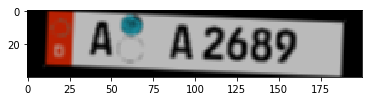

In [3]:
rp_train_dir = os.path.join('Real_Plates', 'train')
sp_train_dir = os.path.join('Synthetic_Plates', 'train')
rp_valid_dir = os.path.join('Real_Plates', 'validation')
sp_valid_dir = os.path.join('Synthetic_Plates', 'validation')
images = []
labels = []
images_rp_train = []
labels_rp_train = []
images_rp_valid = []
labels_rp_valid = []
images_sp_valid = []
labels_sp_valid = []

for img in os.listdir(sp_train_dir):
    images.append(cv2.imread(os.path.join(sp_train_dir, img)))
    labels.append(img.split('.')[0])
    
for img in os.listdir(rp_train_dir):
    images_rp_train.append(cv2.imread(os.path.join(rp_train_dir, img)))
    labels_rp_train.append(img.split('.')[0])
    
for img in os.listdir(rp_valid_dir):
    images_rp_valid.append(cv2.imread(os.path.join(rp_valid_dir, img)))
    labels_rp_valid.append(img.split('.')[0])
    
for img in os.listdir(sp_valid_dir):
    images_sp_valid.append(cv2.imread(os.path.join(sp_valid_dir, img)))
    labels_sp_valid.append(img.split('.')[0])

print('Number of image sp train:', len(images))
print('Number of image sp valid:', len(images_sp_valid))
print('Number of image rp train:', len(images_rp_train))
print('Number of image rp valid:', len(labels_rp_valid))

plt.imshow(images[0])

In [12]:
# Labels processing

labels_final = np.array([len(label.split('_')[0]) for label in labels])
labels_rp_train_final = np.array([len(label.split('_')[0]) for label in labels_rp_train])
labels_rp_valid_final = np.array([len(label.split('_')[0]) for label in labels_rp_valid])
labels_sp_valid_final = np.array([len(label.split('_')[0]) for label in labels_sp_valid])

for labels_, name in zip([labels_final, labels_sp_valid_final, labels_rp_train_final, labels_rp_valid_final], ['Sinthetic Plates train', 'Sinthetic Plates valid', 'Real Plates train', 'Real Plates valid']):
    print(name)
    (unique, counts) = np.unique(labels_, return_counts=True)
    print(*sorted(zip(unique, counts), key=lambda x: -x[1]), sep='\n')
    print('-' * 50)

# Remove 3 images with output number more than 4
index_rp_train_less_than_4 = labels_rp_train_final <=4
# labels_rp_train_final = labels_rp_train_final[index_rp_train_less_than_4]
# images_rp_train = np.array(images_rp_train)[index_rp_train_less_than_4]

Sinthetic Plates train
(3, 3017)
(1, 3016)
(2, 2694)
(4, 245)
--------------------------------------------------
Sinthetic Plates valid
(1, 359)
(3, 319)
(2, 301)
(4, 31)
--------------------------------------------------
Real Plates train
(2, 315)
(3, 227)
(1, 155)
(4, 1)
(6, 1)
(7, 1)
--------------------------------------------------
Real Plates valid
(2, 6)
(3, 3)
(1, 1)
--------------------------------------------------


In [36]:
def transform_images(images_):
    images_new = []
    for image in images_:
        image_new = cv2.resize(image, (200, 40))
        
        # Grayscale
        image_new = cv2.cvtColor(image_new, cv2.COLOR_BGR2GRAY)
        
        # Binarize
        image_new = cv2.threshold(image_new, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # image_new = cv2.adaptiveThreshold(image_new,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,5)
        
        # Remove redundant parts (circle in the large space) 
        contours = cv2.findContours(image_new, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
        for bbox in contours:
            (x, y, w, h) = cv2.boundingRect(bbox)
            if w <= 6 or h <= 15:
                image_new[y:y+h, x:x+w] = 0
                
        # Canny transformation (Fill the letters)
        kernel = np.ones((3, 2), np.uint8)
        image_new = cv2.dilate(image_new, kernel, iterations = 1)
        
        # Cropp the image, to keep only the needed part
        image_new = image_new[:,15:90]
        
        # Expand dimension to fit the model
        image_new = np.expand_dims(image_new, axis=-1)
        
        images_new.append(list(image_new))
        
    return np.array(images_new)

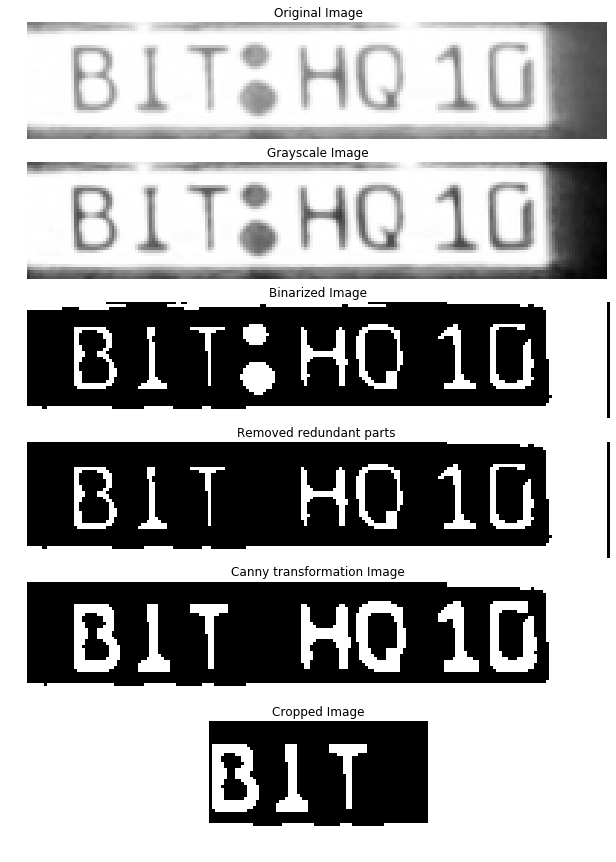

In [46]:
# Example
image = images_rp_train[30]
fig = plt.figure(figsize=(15,15))
columns = 1
rows = 6

image = cv2.resize(image, (200, 40))
ax1 = fig.add_subplot(rows, columns, 1)
plt.imshow(image)
ax1.title.set_text('Original Image')
ax1.set_axis_off()

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax2 = fig.add_subplot(rows, columns, 2)
plt.imshow(image, cmap='gray')
ax2.title.set_text('Grayscale Image')
ax2.set_axis_off()

# image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,5)
image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
ax3 = fig.add_subplot(rows, columns, 3)
plt.imshow(image, cmap='gray')
ax3.title.set_text('Binarized Image')
ax3.set_axis_off()

contours = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
for bbox in contours:
    (x, y, w, h) = cv2.boundingRect(bbox)
    if w <= 6 or h <= 15:
        image[y:y+h, x:x+w] = 0
ax4 = fig.add_subplot(rows, columns, 4)
plt.imshow(image, cmap='gray')
ax4.title.set_text('Removed redundant parts ')
ax4.set_axis_off()

kernel = np.ones((3, 2), np.uint8)
image = cv2.dilate(image, kernel, iterations = 1)
ax5 = fig.add_subplot(rows, columns, 5)
plt.imshow(image, cmap='gray')
ax5.title.set_text('Canny transformation Image')
ax5.set_axis_off()

image = image[:,15:90]
ax6 = fig.add_subplot(rows, columns, 6)
plt.imshow(image, cmap='gray')
ax6.title.set_text('Cropped Image')
ax6.set_axis_off()

plt.show()

In [42]:
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(40, 75, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 38, 73, 16)        160       
_________________________________________________________________
activation_20 (Activation)   (None, 38, 73, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 19, 36, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 17, 34, 32)        4640      
_________________________________________________________________
activation_21 (Activation)   (None, 17, 34, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 17, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 15, 64)         18496     
__________

In [43]:
# Train for synthetic and real plates together first
input_to_model = np.concatenate((transform_images(images), transform_images(images_rp_train))) / 255
labels_to_model = np.concatenate((labels_final, labels_rp_train_final))

indexes = np.arange(input_to_model.shape[0])
np.random.shuffle(indexes)

input_to_model = input_to_model[indexes]
labels_to_model = labels_to_model[indexes] - 1

model.fit(input_to_model, labels_to_model, epochs=30)

# Fine tune for real plates
input_to_model = transform_images(images_rp_train) / 255
labels_to_model = labels_rp_train_final

indexes = np.arange(input_to_model.shape[0])
np.random.shuffle(indexes)

input_to_model = input_to_model[indexes]
labels_to_model = labels_to_model[indexes] - 1

model.fit(input_to_model, labels_to_model, epochs=30)

Epoch 1/30
9670/9670 [==============================] - 23s 2ms/step - loss: 0.4240 - acc: 0.8813
Epoch 2/30
9670/9670 [==============================] - 23s 2ms/step - loss: 0.2582 - acc: 0.9215
Epoch 3/30
9670/9670 [==============================] - 23s 2ms/step - loss: 0.1943 - acc: 0.9347
Epoch 4/30
9670/9670 [==============================] - 24s 3ms/step - loss: 0.1527 - acc: 0.9435
Epoch 5/30
9670/9670 [==============================] - 23s 2ms/step - loss: 0.1229 - acc: 0.9534
Epoch 6/30
9670/9670 [==============================] - 22s 2ms/step - loss: 0.0943 - acc: 0.9678
Epoch 7/30
9670/9670 [==============================] - 23s 2ms/step - loss: 0.0738 - acc: 0.9733
Epoch 8/30
9670/9670 [==============================] - 23s 2ms/step - loss: 0.0604 - acc: 0.9768
Epoch 9/30
9670/9670 [==============================] - 26s 3ms/step - loss: 0.0495 - acc: 0.9819
Epoch 10/30
9670/9670 [==============================] - 25s 3ms/step - loss: 0.0393 - acc: 0.9838
Epoch 11/30
9670/96

In [44]:
# Results
for images_, labels_, name in zip([images, images_sp_valid, images_rp_train, images_rp_valid], 
                                  [labels_final, labels_sp_valid_final, labels_rp_train_final, labels_rp_valid_final], 
                                  ['Sinthetic Plates Train', 'Sinthetic Plates valid', 'Real Plates train', 'Real Plates valid']):
    print(f'{name} accuracy: {model.evaluate(transform_images(images_)/255, labels_ - 1)[1]}')

8972/8972 [==============================] - 8s 903us/step
Sinthetic Plates Train accuracy: 0.9898573339277753
1010/1010 [==============================] - 1s 814us/step
Sinthetic Plates valid accuracy: 0.9772277223001612
698/698 [==============================] - 1s 855us/step
Real Plates train accuracy: 1.0
10/10 [==============================] - 0s 1ms/step
Real Plates valid accuracy: 1.0
